In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


In [2]:
from torchvision.datasets import ImageFolder
from PIL import UnidentifiedImageError


class SafeImageFolder(ImageFolder):
    """
    A subclass of torchvision.datasets.ImageFolder that handles corrupted images gracefully.

    Overrides the __getitem__ method to catch PIL.UnidentifiedImageError exceptions
    caused by corrupted image files. When a corrupted image is encountered, this class
    will print a warning, skip the corrupted image, and attempt to load the next image
    in the dataset.

    This ensures that data loading does not stop training due to corrupted images.

    Attributes:
        None (inherits all from ImageFolder)

    Methods:
        __getitem__(index):
            Attempts to load an image and its label at the given index.
            If the image is corrupted and cannot be opened, prints a warning
            and recursively tries the next index.
            Raises RuntimeError if no valid images remain to be loaded.
    """

    def __getitem__(self, index):
        """
        Retrieve the image and label at the specified index, skipping corrupted images.

        Args:
            index (int): Index of the dataset item to retrieve.

        Returns:
            tuple: (image, label) if the image is successfully loaded.

        Raises:
            RuntimeError: If no valid images remain after skipping corrupted ones.
        """
        try:
            # Try to get the image and label normally
            return super().__getitem__(index)
        except UnidentifiedImageError:
            # Handle corrupted image files by printing a warning and skipping
            print(
                f"Warning: Skipping corrupted image at index {index}: {self.imgs[index][0]}"
            )

            next_index = index + 1
            if next_index < len(self.imgs):
                # Recursively try loading the next image
                return self.__getitem__(next_index)
            else:
                # No more images left to try, raise error to avoid infinite recursion
                raise RuntimeError(
                    "No valid images found after skipping corrupted ones."
                )


In [3]:
# Parameters
val_dir = "../data/val"
model_path = "../catvsdog_model.pth"
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Evaluating on device: {device}")

Evaluating on device: cpu


In [4]:
# Define the same transforms used in training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset and dataloader
val_dataset = SafeImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load model
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(val_dataset.classes))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Evaluation loop
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())


=== Classification Report ===
              precision    recall  f1-score   support

         Cat       0.94      0.82      0.87      2500
         Dog       0.84      0.95      0.89      2500

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000



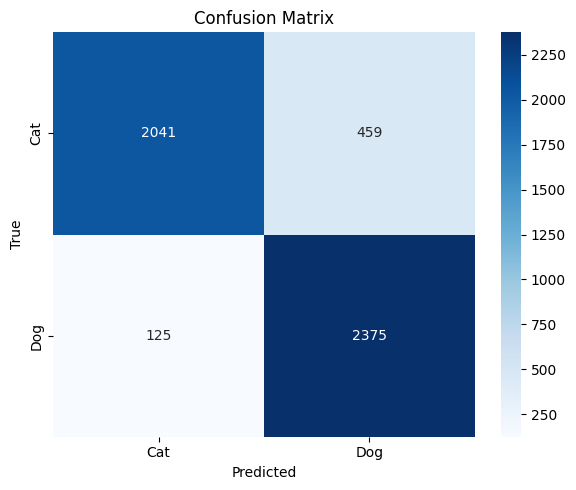

In [6]:
# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=val_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_dataset.classes,
            yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()